# NLP Model for NYT Article-Headlines

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
import nltk
import ssl
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to C:\Users\Nadine
[nltk_data]     Kleine\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Importing the dataframe

In [3]:
data_cl = pd.read_csv('NYT_Australia_articles_cleaned.csv')

In [4]:
data_nlp = data_cl.copy()

In [5]:
data_nlp.head()

,source,headline,keyword1,keyword2,keyword3,pub_date,news_desk,section_name,type_of_material,word_count,month,year
0,NYT,Tensions Over Racism Rock Australian Netball,Australia,others,others,2022-10-30,Foreign,World,News,1321,10,2022
1,NYT,"After Years of ‘Hell’ in ISIS Detention Camp, ...",others,others,Australia,2022-10-29,Foreign,World,News,910,10,2022
2,NYT,How Australia Fell Behind on Data Privacy,others,others,others,2022-10-21,Foreign,World,News,1054,10,2022
3,NYT,New Crack in Apple’s Armor as Dozens Strike at...,others,Australia,others,2022-10-18,Business,Business Day,News,1165,10,2022
4,NYT,Rising Waters Again Force Evacuations and Spre...,Australia,others,others,2022-10-15,Foreign,World,News,395,10,2022


In [6]:
data_hl = data_nlp['headline']

In [7]:
data_hl.head()

0         Tensions Over Racism Rock Australian Netball
1    After Years of ‘Hell’ in ISIS Detention Camp, ...
2            How Australia Fell Behind on Data Privacy
3    New Crack in Apple’s Armor as Dozens Strike at...
4    Rising Waters Again Force Evacuations and Spre...
Name: headline, dtype: object

In [8]:
data_hl = pd.DataFrame(data_hl)

## NLP process

### Tokenization

In [9]:
def tokenizer_and_remove_punctuation(x):
  tokens = word_tokenize(x['headline'])
  return [word.lower() for word in tokens if word.isalpha()]

data_hl['tokenized'] = data_hl.apply(tokenizer_and_remove_punctuation,axis=1)
data_hl.head()

,headline,tokenized
0,Tensions Over Racism Rock Australian Netball,"[tensions, over, racism, rock, australian, net..."
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...","[after, years, of, hell, in, isis, detention, ..."
2,How Australia Fell Behind on Data Privacy,"[how, australia, fell, behind, on, data, privacy]"
3,New Crack in Apple’s Armor as Dozens Strike at...,"[new, crack, in, apple, s, armor, as, dozens, ..."
4,Rising Waters Again Force Evacuations and Spre...,"[rising, waters, again, force, evacuations, an..."


### Lemmatizing

In [10]:
nltk.download('averaged_perceptron_tagger')

tag_dict = {"J": wordnet.ADJ, 
            "N": wordnet.NOUN,
            "V": wordnet.VERB,
            "R": wordnet.ADV}

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper() 
    return tag_dict.get(tag, wordnet.NOUN) 

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Nadine Kleine\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [11]:
lemmatizer = WordNetLemmatizer() 

def lemmatizer_with_pos(row):
  return [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in row['tokenized']]

data_hl['lemmatized'] = data_hl.apply(lemmatizer_with_pos,axis=1)
data_hl.head()

,headline,tokenized,lemmatized
0,Tensions Over Racism Rock Australian Netball,"[tensions, over, racism, rock, australian, net...","[tension, over, racism, rock, australian, netb..."
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...","[after, years, of, hell, in, isis, detention, ...","[after, year, of, hell, in, isi, detention, ca..."
2,How Australia Fell Behind on Data Privacy,"[how, australia, fell, behind, on, data, privacy]","[how, australia, fell, behind, on, data, privacy]"
3,New Crack in Apple’s Armor as Dozens Strike at...,"[new, crack, in, apple, s, armor, as, dozens, ...","[new, crack, in, apple, s, armor, a, dozen, st..."
4,Rising Waters Again Force Evacuations and Spre...,"[rising, waters, again, force, evacuations, an...","[rise, water, again, force, evacuation, and, s..."


### Removing Stopwords (english)

In [12]:
def remove_sw(row):
  return [word for word in row['lemmatized'] if not word in stopwords.words('english')]

data_hl['no_stopwords'] = data_hl.apply(remove_sw,axis=1)
data_hl.head()

,headline,tokenized,lemmatized,no_stopwords
0,Tensions Over Racism Rock Australian Netball,"[tensions, over, racism, rock, australian, net...","[tension, over, racism, rock, australian, netb...","[tension, racism, rock, australian, netball]"
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...","[after, years, of, hell, in, isis, detention, ...","[after, year, of, hell, in, isi, detention, ca...","[year, hell, isi, detention, camp, australian,..."
2,How Australia Fell Behind on Data Privacy,"[how, australia, fell, behind, on, data, privacy]","[how, australia, fell, behind, on, data, privacy]","[australia, fell, behind, data, privacy]"
3,New Crack in Apple’s Armor as Dozens Strike at...,"[new, crack, in, apple, s, armor, as, dozens, ...","[new, crack, in, apple, s, armor, a, dozen, st...","[new, crack, apple, armor, dozen, strike, stor..."
4,Rising Waters Again Force Evacuations and Spre...,"[rising, waters, again, force, evacuations, an...","[rise, water, again, force, evacuation, and, s...","[rise, water, force, evacuation, spread, miser..."


### Reducing the words to the most common 1000

In [13]:
def re_blob(row):
  return " ".join(row['no_stopwords'])

data_hl['clean_blob'] = data_hl.apply(re_blob,axis=1)
data_hl.head()

,headline,tokenized,lemmatized,no_stopwords,clean_blob
0,Tensions Over Racism Rock Australian Netball,"[tensions, over, racism, rock, australian, net...","[tension, over, racism, rock, australian, netb...","[tension, racism, rock, australian, netball]",tension racism rock australian netball
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...","[after, years, of, hell, in, isis, detention, ...","[after, year, of, hell, in, isi, detention, ca...","[year, hell, isi, detention, camp, australian,...",year hell isi detention camp australian return...
2,How Australia Fell Behind on Data Privacy,"[how, australia, fell, behind, on, data, privacy]","[how, australia, fell, behind, on, data, privacy]","[australia, fell, behind, data, privacy]",australia fell behind data privacy
3,New Crack in Apple’s Armor as Dozens Strike at...,"[new, crack, in, apple, s, armor, as, dozens, ...","[new, crack, in, apple, s, armor, a, dozen, st...","[new, crack, apple, armor, dozen, strike, stor...",new crack apple armor dozen strike store austr...
4,Rising Waters Again Force Evacuations and Spre...,"[rising, waters, again, force, evacuations, an...","[rise, water, again, force, evacuation, and, s...","[rise, water, force, evacuation, spread, miser...",rise water force evacuation spread misery aust...


In [14]:
bow_vect = CountVectorizer(max_features=1000)

X = bow_vect.fit_transform(data_hl['clean_blob']).toarray()

In [16]:
data_model = pd.DataFrame(X,columns=bow_vect.get_feature_names())
data_model.head(50)

C:\Users\Nadine Kleine\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aboriginal,abortion,abroad,abuse,accuse,across,act,action,activist,add,...,wrong,wuhan,xi,xinjiang,year,yemen,yet,york,young,zealand
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
data_model.shape

(12818, 1000)

## Building cluster

In [23]:
import matplotlib.pyplot as plt

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

In [27]:
from sklearn import cluster
kmeans = cluster.KMeans(n_clusters=6,random_state=100)
kmeans.fit(X)
pred = kmeans.predict(X)

### Finding k with elbow

Text(0.5, 1.0, 'Elbow Method showing the optimal k')

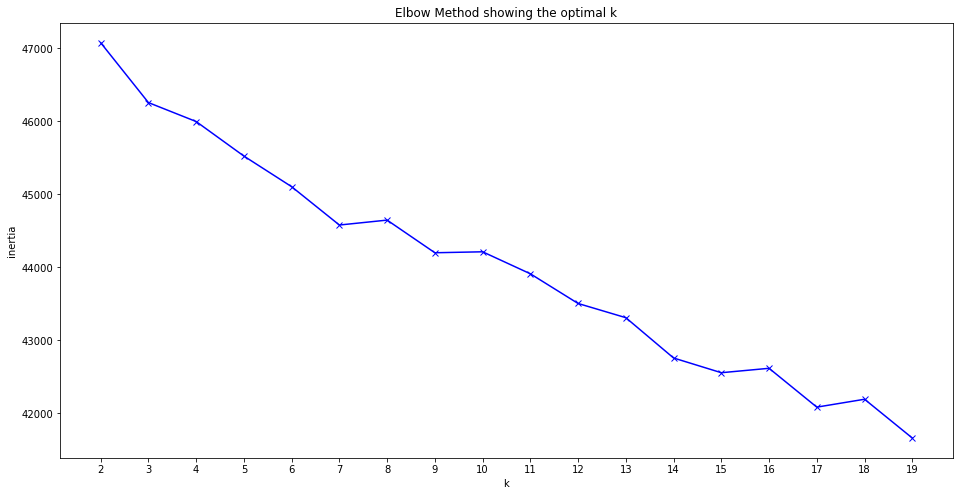

In [28]:
K = range(2, 20) #NC:  2 to 19 clusters
inertia = [] # NC: list of inertia numbers

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Elbow Method showing the optimal k')

In [ ]:
# elbow shows 7 or 9 as optimal k

### Finding k with silhouette

Text(0.5, 1.0, 'Slhouette score showing the optimal k')

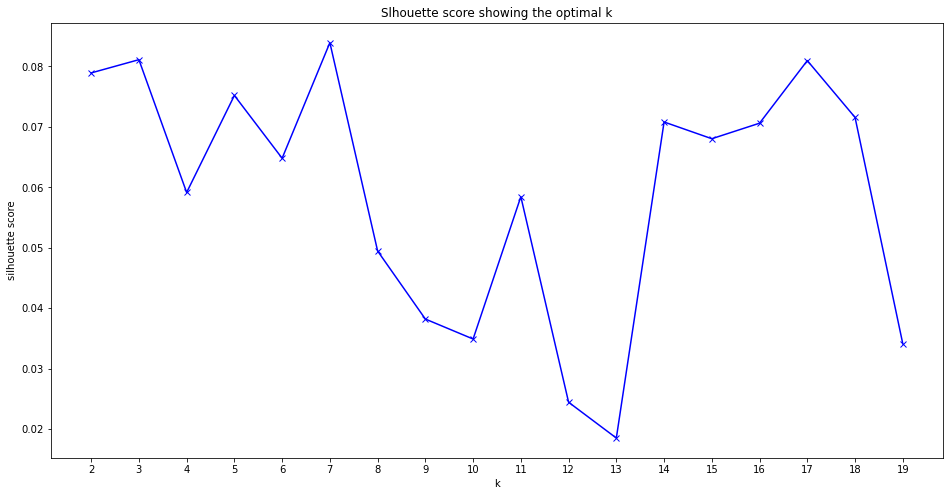

In [30]:
from sklearn.metrics import silhouette_score
K = range(2, 20)
silhouette = []

for k in K:
    kmeans = KMeans(n_clusters=k,
                    random_state=1234)
    kmeans.fit(X)
    silhouette.append(silhouette_score(X, kmeans.predict(X)))


plt.figure(figsize=(16,8))
plt.plot(K, silhouette, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.xticks(np.arange(min(K), max(K)+1, 1.0))
plt.title('Slhouette score showing the optimal k')

In [ ]:
# silhouette shows 7 as optimal k

### --> choosing 7 as optimal k!

In [32]:
kmeans = cluster.KMeans(n_clusters=7,random_state=100)
kmeans.fit(X)
pred = kmeans.predict(X)

In [34]:
data_pred = pd.concat([data_hl['headline'],pd.DataFrame(pred,columns=['cluster'])],axis=1)
data_pred.head(30)

,headline,cluster
0,Tensions Over Racism Rock Australian Netball,4
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...",4
2,How Australia Fell Behind on Data Privacy,4
3,New Crack in Apple’s Armor as Dozens Strike at...,3
4,Rising Waters Again Force Evacuations and Spre...,4
5,5 Australian Women Sue Qatar Over Invasive Sea...,4
6,The Future of Australian Children’s TV,4
7,Australia Aims to Cut Its High Rate of Species...,4
8,She Says She Was Raped in Parliament. Now Her ...,4
9,Brittany Higgins Takes the Stand,4


In [35]:
data_pred['cluster'].value_counts(dropna=False)

4    8869
6    1570
3     770
5     494
1     480
2     463
0     172
Name: cluster, dtype: int64

### Exploring clusters:

In [37]:
pd.set_option("display.max_rows", None)

In [38]:
data_pred[data_pred['cluster']==0]

,headline,cluster
1278,Coronavirus Briefing: Omicron and the Need for...,0
1415,Coronavirus Briefing: What Happened Today,0
1632,Coronavirus Briefing: Omicron vs. vaccines,0
1658,Coronavirus Briefing: Shots for Young Kids,0
1686,Coronavirus Briefing: Rethinking more boosters,0
1690,Coronavirus Briefing: What doctors say about O...,0
1697,Coronavirus Briefing: Supreme Court Blocks Vac...,0
1708,Coronavirus Briefing: Living With the Virus,0
1709,Coronavirus Briefing: Back-to-school chaos,0
1717,Coronavirus Briefing: Another Booster? Not Yet,0


In [ ]:
# Cluster 0: pretty clear: Corona

In [39]:
data_pred[data_pred['cluster']==1]

,headline,cluster
24,Referendum Seeks to Mend the Open Wound at Aus...,1
183,"Still Unvaccinated, Djokovic Says He Will Miss...",1
185,Serena Williams Has a Path to Proceed in U.S. ...,1
199,Cameron Smith Overtakes Rory McIlroy to Win th...,1
214,Defending U.S. Open Champion Emma Raducanu Los...,1
232,"Rafael Nadal Falls Apart on Clay, Just in Time...",1
234,A Surprising Year Could Culminate in a Surpris...,1
249,One Golfer Not Welcome at the British Open? Gr...,1
252,Nick Kyrgios’s U.S. Open Run Ends One Match Af...,1
256,Frances Tiafoe Downs Rafael Nadal at U.S. Open,1


In [ ]:
# Cluster 1: mostly tennis, other findings (just very few): Trump, musical

In [40]:
data_pred[data_pred['cluster']==2]

,headline,cluster
34,Your Wednesday Briefing: Tensions Rise in the ...,2
51,Your Wednesday Briefing: Putin and Xi Prepare ...,2
76,Your Wednesday Briefing: New Blasts Shake Crimea,2
161,Your Wednesday Briefing: The End of Roe?,2
228,Your Wednesday Evening Briefing,2
253,Your Wednesday Briefing: Calls to Free Up Ukra...,2
270,Your Wednesday Briefing,2
367,Your Wednesday Briefing: Russia Moves Toward A...,2
370,"Your Wednesday Briefing: Sri Lanka, Out of Fuel",2
655,Your Wednesday Briefing: Ukraine gains ground ...,2


In [ ]:
# Cluster 2: Wednesday Briefing?

In [41]:
data_pred[data_pred['cluster']==3]

,headline,cluster
3,New Crack in Apple’s Armor as Dozens Strike at...,3
30,Australian Judge Orders New Trial in Rape Case...,3
32,"For Many Disabled People, a Battle to Stay in ...",3
52,A Test Case for Australia’s Broad New Law Agai...,3
71,New York City Finally Gets Its Aman,3
74,"In New Zealand, a 23-Million-Year-Old Fossil I...",3
81,Woman Is Arrested in South Korea Over Deaths o...,3
83,Climate Protesters in Australia Face Harsh New...,3
92,Could New Zealand Change Its Name?,3
93,Remains of 2 Children Are Found in Suitcases B...,3


In [ ]:
# Cluster 3: Australia, New Zealand, Oceania, TV shows - less clear, more mix

In [42]:
data_pred[data_pred['cluster']==4]

,headline,cluster
0,Tensions Over Racism Rock Australian Netball,4
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...",4
2,How Australia Fell Behind on Data Privacy,4
4,Rising Waters Again Force Evacuations and Spre...,4
5,5 Australian Women Sue Qatar Over Invasive Sea...,4
6,The Future of Australian Children’s TV,4
7,Australia Aims to Cut Its High Rate of Species...,4
8,She Says She Was Raped in Parliament. Now Her ...,4
9,Brittany Higgins Takes the Stand,4
10,Australia’s Proposed Integrity Commission Woul...,4


In [ ]:
# Cluster 4: Racism, Crime, Melbourne, Tennis, Misinformation, Australia's Election, China, Politics, world affairs
# very broad

In [43]:
data_pred[data_pred['cluster']==5]

,headline,cluster
58,Your Friday Briefing: Queen Elizabeth II Dies ...,5
113,Your Friday Briefing: A Major U.S. Climate Ruling,5
203,Your Friday Briefing: Russia Sentences Brittne...,5
204,Your Friday Briefing: Russia Seeks More Contro...,5
210,Your Friday Briefing: Biden and Xi’s Fraught P...,5
380,Your Friday Briefing: A Crucial Moment in the ...,5
611,Your Friday Briefing,5
625,Your Friday Briefing: Ukraine Launches a South...,5
640,Your Friday Briefing,5
650,Your Friday Evening Briefing,5


In [ ]:
# Cluster 5: Friday Briefing

In [44]:
data_pred[data_pred['cluster']==6]

,headline,cluster
35,Your Thursday Briefing: Iran’s Protests Intensify,6
44,Your Thursday Briefing: Iran Strikes Kurds in ...,6
53,Your Tuesday Briefing: Ukraine’s Advance Conti...,6
78,Your Tuesday Briefing: Kenya’s Next President?,6
79,Your Monday Briefing: U.S. Lawmakers Visit Taiwan,6
138,Your Thursday Briefing: Russia’s Land Bridge,6
139,Your Monday Briefing: Australia’s New Leader,6
156,Your Tuesday Briefing: Russia’s Faltering Camp...,6
190,Your Tuesday Briefing: Hot Weather Grips Britain,6
197,Your Monday Briefing: Record Heat Disrupts China,6


In [ ]:
# Cluster 6: Monday Briefing, Tuesday Briefing, Thursday Briefing, Weekend Briefing

### Conclusion of the Headline Cluster:

In [45]:
data_pred['cluster'].value_counts(dropna=False)

4    8869
6    1570
3     770
5     494
1     480
2     463
0     172
Name: cluster, dtype: int64

In [ ]:
# Headline cluster with value counts (desc) & probable cluster topic(s):

# Cluster 4 (8869): Mixed, 
    # esp.: Racism, Crime, Melbourne, Tennis, Misinformation, Australia's Election, China, Politics, world affairs

# Cluster 6 (1570): Briefings - Monday Briefing, Tuesday Briefing, Thursday Briefing, Weekend Briefing

# Cluster 3 (770): Oceania-Mix and TV --> Australia, New Zealand, Oceania, TV shows - less clear, more mix

# Cluster 5 (494): Friday Briefing

# Cluster 1 (480): Tennis! --> other, very few findings: Trump, musical

# Cluster 2 (463): Wednesday Briefing

# Cluster 0 (172): Covid


## Saving df as csv: 

In [51]:
data_pred.to_csv('NYT_Australia_articles_NLPcluster.csv', index=False)

In [47]:
data_pred.head()

,headline,cluster
0,Tensions Over Racism Rock Australian Netball,4
1,"After Years of ‘Hell’ in ISIS Detention Camp, ...",4
2,How Australia Fell Behind on Data Privacy,4
3,New Crack in Apple’s Armor as Dozens Strike at...,3
4,Rising Waters Again Force Evacuations and Spre...,4


In [49]:
data_pred.shape

(12818, 2)